In [1]:
import matplotlib.pyplot as plt
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
import kagglehub
from sklearn.compose import ColumnTransformer
import os
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Download the latest version
path = kagglehub.dataset_download("ihelon/coffee-sales")
path1 = path + "/index_1.csv"
path2 = path + "/index_2.csv"

# Load the dataset
df1 = pd.read_csv(path1)
df2 = pd.read_csv(path2)
df = pd.concat([df1, df2], ignore_index=True)

In [2]:
# check if datetime column is in datetime format
if (df['datetime'].dtype == object):
  df['datetime'] = pd.to_datetime(df['datetime'], format='mixed', errors='coerce')

# group data by date
grouped_data = df.groupby('date')
daily_sales = grouped_data['money'].sum()

# Separate features and target
categorical_features = ['cash_type', 'coffee_name']
daily_sales = daily_sales.reset_index().rename(columns={'money': 'sales'})

In [3]:

daily_sales['date'] = pd.to_datetime(daily_sales['date'])
start_date = daily_sales['date'].min()
daily_sales['days_since_start'] = (daily_sales['date'] - start_date).dt.days

In [4]:
# Split the dataset into an 80-20 training-test set
X = daily_sales[['days_since_start']]
y = daily_sales['sales']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# # Create an instance of the StandardScaler class
# ss = StandardScaler()

# # Fit the StandardScaler on the features from the training set and transform it
# X_train = ss.fit_transform(X_train)

# # Apply the transform to the test set
# X_test = ss.transform(X_test)

# # Print the scaled training and test datasets

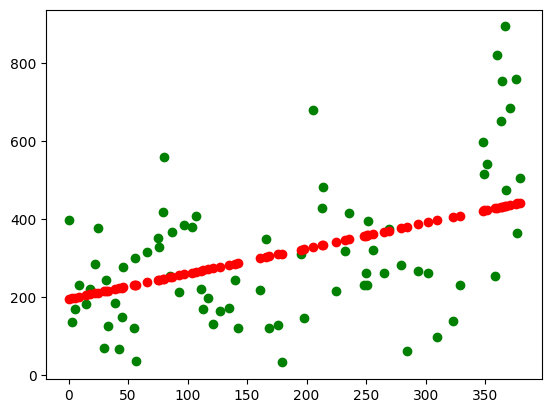

In [5]:
# Evaluate
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Save to txt file
with open('model_metrics.txt', 'w') as f:
    f.write(f"Mean Absolute Error: {mae}\n")
    f.write(f"Mean Squared Error: {mse}\n")
    f.write(f"R2 Score: {r2}")

# Plot
plt.scatter(X_test, y_test, color='green', label='Actual')
plt.scatter(X_test, y_pred, color='red', label='Predicted')


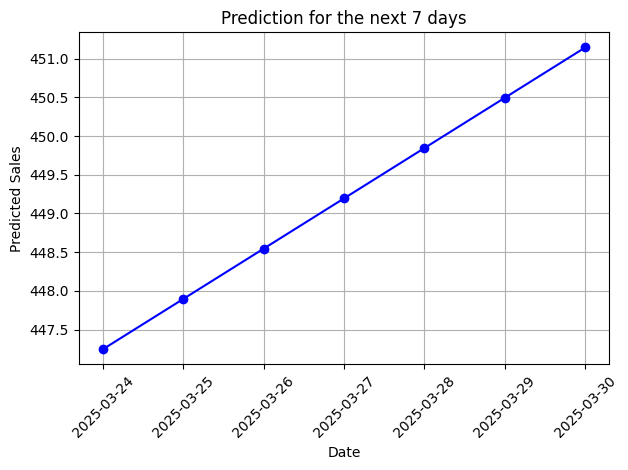

In [6]:
last_day = daily_sales['days_since_start'].max()
future_days = pd.DataFrame({'days_since_start': range(last_day + 1, last_day + 8)})

future_predictions = model.predict(future_days)

future_days['predicted_sales'] = future_predictions
future_days['date'] = pd.to_datetime(daily_sales['date'].max()) + pd.to_timedelta(future_days['days_since_start'] - daily_sales['days_since_start'].max(), unit='d')

# Save predictions to CSV
future_days[['date', 'predicted_sales']].to_csv('future_predictions.csv', index=False)

# Visualize future broadcasts
plt.plot(future_days['date'], future_days['predicted_sales'], marker='o', color='blue')
plt.title('Prediction for the next 7 days')
plt.xlabel('Date')
plt.ylabel('Predicted Sales')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()